In [ ]:
!pip install wandb

     |████████████████████████████████| 1.7 MB 5.5 MB/s 
     |████████████████████████████████| 140 kB 36.8 MB/s 
     |████████████████████████████████| 97 kB 6.6 MB/s 
     |████████████████████████████████| 180 kB 48.6 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-py3-none-any.whl size=6502 sha256=e4d9c465b92c0eb7ad6fbbe4e97afd9790e9b272759adf60c9f6f668e3d4fa86
  Stored in directory: /root/.cache/pip/wheels/50/ca/fa/8fca8d246e64f19488d07567547ddec8eb084e8c0d7a59226a
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8807 sha256=db62b8362b30ab74feefc2d4c34f4865cb2c1707196318f1541aacbf15c62ecf
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built subprocess32 pathtools


In [ ]:
import wandb
run = wandb.init('babycry', entity='babycry', name='data_upload')
artifact = run.use_artifact('bijin/baby_cry/Mel_Spectrograms_Vertical:v1', type='image')
data_dir = artifact.download()

<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


wandb: Downloading large artifact Mel_Spectrograms_Vertical:v1, 155.70MB. 3822 files... Done. 0:0:0


In [ ]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

In [ ]:
print(tf.__version__)

2.7.0


In [ ]:
import pathlib

dataset_folder = '/content/artifacts/Mel_Spectrograms_Vertical:v1'
data_dir = pathlib.Path(data_dir)

image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

3822


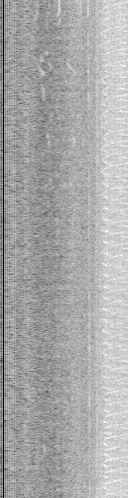

In [ ]:
ambient = list(data_dir.glob('ambient/*'))
PIL.Image.open(str(ambient[0]))

In [ ]:
batch_size = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    batch_size=batch_size)

Found 3822 files belonging to 6 classes.
Using 3058 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    batch_size=batch_size)

Found 3822 files belonging to 6 classes.
Using 764 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['ambient', 'awake', 'hug', 'hungry', 'sleepy', 'uncomfortable']


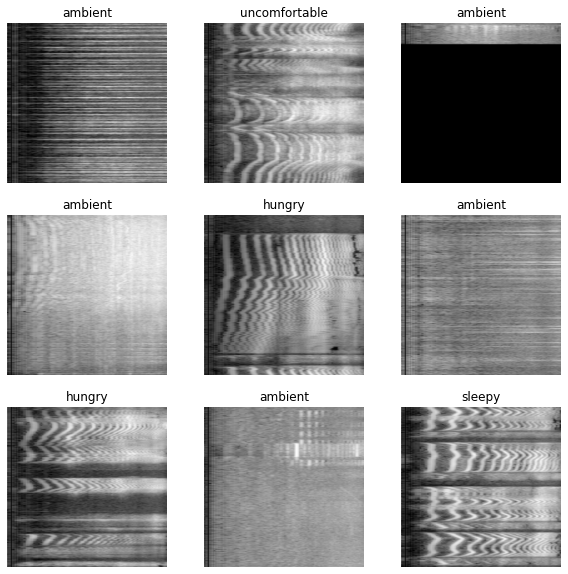

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 256, 256, 3)
(32,)


In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.9940641


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
num_classes = 6

# model = tf.keras.Sequential([
#     tf.keras.layers.Rescaling(1./255),
#     tf.keras.layers.Conv2D(32, 3, activation='relu'),
#     tf.keras.layers.MaxPooling2D(),
#     tf.keras.layers.Conv2D(32, 3, activation='relu'),
#     tf.keras.layers.MaxPooling2D(),
#     tf.keras.layers.Conv2D(32, 3, activation='relu'),
#     tf.keras.layers.MaxPooling2D(),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(128, activation='relu'),
#     tf.keras.layers.Dense(num_classes)
# ])

In [ ]:
# model.compile(
#     optimizer='adam',
#     loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
#     metrics=['accuracy']
# )

In [ ]:
# history = model.fit(
#     train_ds,
#     validation_data=val_ds,
#     epochs=10
# )

In [ ]:
from tensorflow.keras import models, layers

input_shape=(256,256,3)
CNNmodel = models.Sequential()
CNNmodel.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
CNNmodel.add(layers.MaxPooling2D((2, 2)))
CNNmodel.add(layers.Dropout(0.2))
CNNmodel.add(layers.Conv2D(64, (3, 3), activation='relu'))
CNNmodel.add(layers.MaxPooling2D((2, 2)))
CNNmodel.add(layers.Dropout(0.2))
CNNmodel.add(layers.Conv2D(64, (3, 3), activation='relu'))
CNNmodel.add(layers.Flatten())
CNNmodel.add(layers.Dense(64, activation='relu'))
CNNmodel.add(layers.Dropout(0.2))
CNNmodel.add(layers.Dense(32, activation='relu'))
CNNmodel.add(layers.Dense(24, activation='softmax'))

In [ ]:
CNNmodel.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [ ]:
history = CNNmodel.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15
)

Epoch 1/15
96/96 [==============================] - 34s 203ms/step - loss: 21.9096 - accuracy: 0.3509 - val_loss: 2.8318 - val_accuracy: 0.4895
Epoch 2/15
96/96 [==============================] - 16s 167ms/step - loss: 1.5797 - accuracy: 0.4902 - val_loss: 2.5209 - val_accuracy: 0.4961
Epoch 3/15
96/96 [==============================] - 16s 167ms/step - loss: 1.2995 - accuracy: 0.5131 - val_loss: 1.3444 - val_accuracy: 0.4987
Epoch 4/15
96/96 [==============================] - 16s 168ms/step - loss: 1.1507 - accuracy: 0.5389 - val_loss: 1.2256 - val_accuracy: 0.5602
Epoch 5/15
96/96 [==============================] - 16s 166ms/step - loss: 1.0989 - accuracy: 0.5683 - val_loss: 1.1586 - val_accuracy: 0.5890
Epoch 6/15
96/96 [==============================] - 16s 167ms/step - loss: 1.0030 - accuracy: 0.5922 - val_loss: 1.2092 - val_accuracy: 0.5838
Epoch 7/15
96/96 [==============================] - 16s 168ms/step - loss: 0.9646 - accuracy: 0.6099 - val_loss: 1.1739 - val_accuracy: 0.579

In [ ]:
import matplotlib.pyplot as plt

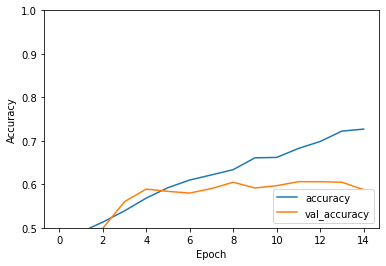

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [ ]:
!nvidia-smi

Wed Dec 15 10:58:57 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P0    62W / 149W |   6424MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------